# CNN + residual NN

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
data = fetch_openml('CIFAR_10')

In [37]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
print(data["data"].shape)
#we get the data and the target
X = data["data"].to_numpy()
y = data["target"].to_numpy().astype(int)

print(X.shape, y.shape)
N_samples = X.shape[0]


(60000, 3072)
(60000, 3072) (60000,)


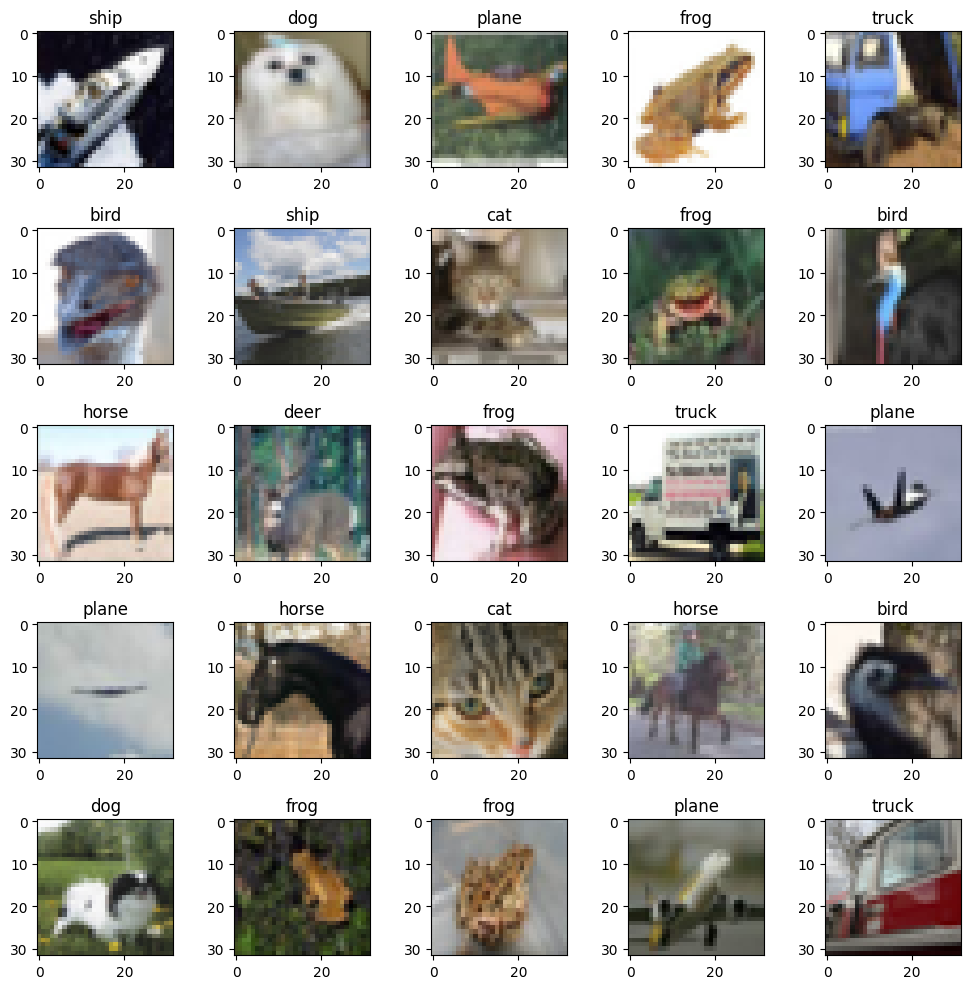

In [32]:
def plot_image(x, y, ax):
    x = x.reshape(3,32,32)
    #to plot matplotlib needs to have channels last
    x = x.transpose(1,2,0)
    ax.imshow(x)
    ax.set_title(classes[y])

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    plot_image(X[i,:], y[i], ax)
plt.tight_layout()
plt.show()


### Prepare training and val set

In [49]:
from sklearn.model_selection import train_test_split

#we set 15% of the data for validation
X = X/255
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

torch.Size([51000, 3072]) torch.Size([9000, 3072]) torch.Size([51000]) torch.Size([9000])


### Dataloader and dataset

Dataset takes care of adding transformation to the images. We separate static and random transformations. The validation set will only see the static transformation as the random transforms are for data augmentation during training

In [54]:
class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, static_transform=None, random_transform=None):
        self.X = X
        self.y = y
        self.static_transform = static_transform
        self.random_transform = random_transform

    #should return the number of samples
    def __len__(self):
        return len(self.X)
    
    #should return a tuple of (image, label)
    def __getitem__(self, idx):
        image = self.X[idx].reshape(3,32,32)
        label = self.y[idx]
        
        if self.static_transform:
            image = self.static_transform(image)
        
        #only during training
        if self.random_transform:
            image = self.random_transform(image)
        
        return image, label

class CIFAR10DataLoader(torch.utils.data.DataLoader):
    def __init__(self, X, y, batch_size=32, shuffle=True, static_transform=None, random_transform=None):
        #generate dataset with transforms
        dataset = CIFAR10Dataset(X, y, static_transform, random_transform)
        #this calls the abstract class
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]


mean = X_train.reshape(-1, 3, 32, 32).mean(dim=(0,2,3))
std = X_train.reshape(-1, 3, 32, 32).std(dim=(0,2,3))

static_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])


random_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(0, shear=15, scale=(0.8, 1.2))
])

train_dataset = CIFAR10Dataset(X_train, y_train, static_transforms, random_transforms)
train_loader = CIFAR10DataLoader(X_train, y_train, batch_size=32, shuffle=True, static_transform=static_transforms, random_transform=random_transforms)

val_dataset = CIFAR10Dataset(X_val, y_val, static_transforms)
val_loader = CIFAR10DataLoader(X_val, y_val, batch_size=32, shuffle=False, static_transform=static_transforms)

### MODEL CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels=3, channels=[32, 64, 128, 256], out_channels=len(classes)):
        super().__init__()
        self.blocks = nn.ModuleList()
        for i in range(len(channels)):
            self.blocks.append(nn.Conv2d(in_channels, channels[i], kernel_size=3, stride=1, padding=1))
            self.blocks.append(nn.BatchNorm2d(channels[i]))
            self.blocks.append(nn.ReLU())
            self.blocks.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = channels[i]
        self.blocks.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
        
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return x